### Model Exploration

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

Load in dataset and create training and test subsets. Create a function to run models and output their accuracy.

In [2]:
def load_data(bin=False):
    project_dir = os.path.dirname(os.path.abspath(''))
    df = pd.read_json(os.path.join(project_dir, 'model_prepped_dataset.json'))
    X = df.loc[:, ~df.columns.isin(['Outcome', 'Outcome_Bin_H'])]
    if bin:
        y = df['Outcome_Bin_H']
    else:
        y = df['Outcome']
    X = X.drop([
    'Day',
    'Season',
    'Home_Team_Streak',
    'Away_Team_Streak',
    'Home_Team_Home_Streak',
    'Away_Team_Away_Streak',
    'Match_Relevance',
    'Home_Team_Home_Form',
    'Away_Team_Away_Form',
    'Home_Team_Home_Goals',
    'Away_Team_Away_Goals'
    ], axis=1)
    return X, y

def prep_datasets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

def compare_models(models, X_train, y_train, y_test):
    for model in models:
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        accu = accuracy_score(y_test, y_pred) * 100
        print(
            f"{model[0]}: "
            f"Accuracy: {accu:.2f}"
            )
    return

Define various models and run them so that they can be compared. Where scaling is required, it is done so via the inclusion of a pipeline.

In [3]:
np.random.seed(2)

models = [
    ('lgr', make_pipeline(StandardScaler(), LogisticRegression())),
    ('rfc', RandomForestClassifier(max_depth=2)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
    ('dtc', DecisionTreeClassifier()),
    ('abc', AdaBoostClassifier()),
    ('gbc', GradientBoostingClassifier())
    ]

X, y = load_data(bin=True)
X_train, X_test, y_train, y_test = prep_datasets(X, y)
compare_models(models, X_train, y_train, y_test)

lgr: Accuracy: 60.76
rfc: Accuracy: 59.05
knn: Accuracy: 56.08
dtc: Accuracy: 54.13
abc: Accuracy: 60.65
gbc: Accuracy: 60.73


(Example only) View the importance of features in the random forest classification model.

<BarContainer object of 7 artists>

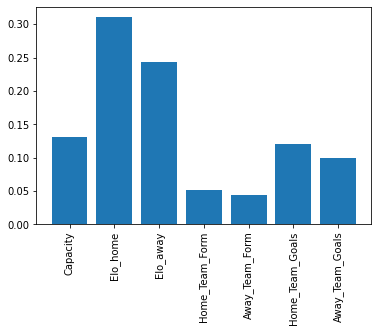

In [4]:
plt.xticks(rotation=90)
plt.bar(list(X), models[1][1].feature_importances_)

As there is very little difference between models with default parameters, the logistic regression model is selected for hyperparameter tuning via grid search.

There are two approaches for this with respect to splitting the dataset:
1) Split dataset into three folds: train, validation, and test. Then, perform the model selection and hyperparameter search, each time training on the train set, and checking the score on the validation set.
2) Split into two folds: train and test, and then perform cross-validations on the train set to do the model selection and hyperparameter search. This time, thre is specific validation set but as many as there are folds in the cross validation, making it more robust.

In [5]:
X, y = load_data(bin=True)
X_train, X_test, y_train, y_test = prep_datasets(X, y)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
model_1 = LogisticRegression()
params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

cv = KFold(n_splits=10, random_state=1, shuffle=True)
grid_search = GridSearchCV(model_1, params, scoring='accuracy', n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_mode

Best Score: 60.77%
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


Now we know the best model hyperparameters and will apply these to the model.

Using these best parameters we can also experiment with different cross validation techniques to see how these impact the output scores at each fold and to validate that the model is outputting consistent predictions.

In [6]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

cv_techniques = [
    ('K-Fold CV', KFold(n_splits=5, random_state=1, shuffle=True)),
    ('Time Series CV', TimeSeriesSplit(n_splits=10)),
    ('Blocking Time Series CV', BlockingTimeSeriesSplit(n_splits=10))
]

model_1 = LogisticRegression(solver='newton-cg', penalty='l2', C=0.01)

for cvs in cv_techniques:

    accu = cross_val_score(model_1, X_train, y_train, cv=cvs[1], n_jobs=-1, scoring='accuracy')
    accu = [f'{a * 100:.2f}%' for a in accu]
    print(f'{cvs[0]}: {accu}')

K-Fold CV: ['60.79%', '60.95%', '60.38%', '61.21%', '60.30%']
Time Series CV: ['60.41%', '61.53%', '61.39%', '61.12%', '60.68%', '59.92%', '60.97%', '61.71%', '60.19%', '59.52%']
Blocking Time Series CV: ['59.59%', '60.68%', '58.50%', '62.06%', '59.67%', '58.21%', '61.26%', '62.43%', '62.14%', '58.14%']


We can also carry out a random search for the best hyperparameters on a different model, in this case Random Forest. This will allows us to statistically compare the models later. As this is a comparator only, only some of the hyperparamaters are tuned, to aid performace.

In [7]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 20)]
max_depth = [int(x) for x in np.linspace(2, 32, num = 4)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

model_2 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, search across 20 different combinations, and use all available cores
rdm_search = RandomizedSearchCV(estimator = model_2, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rdm_search.fit(X_train, y_train)
print(f'Best Score: {rdm_search.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {rdm_search.best_params_}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ....................max_depth=None, n_estimators=87; total time=  28.6s
[CV] END ....................max_depth=None, n_estimators=87; total time=  28.8s
[CV] END ....................max_depth=None, n_estimators=87; total time=  32.8s
[CV] END .....................max_depth=22, n_estimators=345; total time= 1.8min
[CV] END .....................max_depth=32, n_estimators=267; total time= 1.5min
[CV] END .....................max_depth=22, n_estimators=345; total time= 1.9min
[CV] END .....................max_depth=22, n_estimators=345; total time= 1.9min
[CV] END .....................max_depth=22, n_estimators=138; total time=  38.8s
[CV] END .....................max_depth=22, n_estimators=138; total time=  42.8s
[CV] END .....................max_depth=32, n_estimators=267; total time= 1.4min
[CV] END .....................max_depth=32, n_estimators=267; total time= 1.4min
[CV] END .....................max_depth=22, n_es

# WIP UPDTE DOC

To verify that the model is increases the accuracy of predictions and test the null hypothesis, it can be compared to a simple random choice predictor.
https://towardsdatascience.com/validating-your-machine-learning-model-25b4c8643fb7

In [12]:
model_1 = LogisticRegression(solver='newton-cg', penalty='l2', C=0.01)
model_1.fit(X_train, y_train)
model_2 = RandomForestClassifier(n_estimators=293, max_depth=12)
model_2.fit(X_train, y_train)
lgr_scores = cross_val_score(model_1, X_train, y_train, cv=cv_techniques[0][1], n_jobs=-1, scoring='accuracy')
rfc_scores = cross_val_score(model_2, X_train, y_train, cv=cv_techniques[0][1], n_jobs=-1, scoring='accuracy')

from scipy.stats import wilcoxon
stat, p = wilcoxon(lgr_scores, rfc_scores, zero_method='zsplit')
stat, p

(5.0, 0.625)

We can apply this significance test for comparing two Machine Learning models. Using k-fold cross-validation we can create, for each model, k accuracy scores. This will result in two samples, one for each model.
Then, we can use the Wilcoxon signed-rank test to test if the two samples differ significantly from each other. If they do, then one is more accurate than the other.

The result will be a p-value. If that value is lower than 0.05 we can reject the null hypothesis that there are no significant differences between the models.
NOTE: It is important that you keep the same folds between the models to make sure the samples are drawn from the same population. This is achieved by simply setting the same random_state in the cross-validation procedure.

McNemar’s test is used to check the extent to which the predictions between one model and another match. This is referred to as the homogeneity of the contingency table. From that table, we can calculate x² which can be used to compute the p-value:

Again, if the p-value is lower than 0.05 we can reject the null hypothesis and see that one model is significantly better than the other.
We can use mlxtend package to create the table and calculate the corresponding p-value:

In [15]:
import numpy as np
from mlxtend.evaluate import mcnemar_table, mcnemar

lgr_predict = model_1.predict(X_test)
print(f'{accuracy_score(y_test, lgr_predict) * 100:.2f}%')
rfc_predict = model_2.predict(X_test)
print(f'{accuracy_score(y_test, rfc_predict) * 100:.2f}%')

# Calculate p value
tb = mcnemar_table(y_target = y_test, 
                   y_model1 = lgr_predict, 
                   y_model2 = rfc_predict)
chi2, p = mcnemar(ary=tb, exact=True)

print('chi-squared:', chi2)
print('p-value:', p)

60.72603901611535
60.59033078880407
chi-squared: 1672
p-value: 0.5025934574996221


The 5x2CV paired t-test is a method often used to compare Machine Learning models due to its strong statistical foundation.
The method works as follows. Let’s say we have two classifiers, A and B. We randomly split the data in 50% training and 50% test. Then, we train each model on the training data and compute the difference in accuracy between the models from the test set, called DiffA. Then, the training and test splits are reversed and the difference is calculated again in DiffB.
This is repeated five times after which the mean variance of the differences is computed (S²). Then, it is used to calculate the t-statistic:

NOTE: You can use the combined 5x2CV F-test instead which was shown to be slightly more robust (Alpaydin, 1999). This method is implemented in mlxtend as
from mlxtend.evluate import combined_ftest_5x2cv.

In [16]:
from mlxtend.evaluate import paired_ttest_5x2cv

# Calculate p-value
t, p = paired_ttest_5x2cv(estimator1 = model_1,
                          estimator2 = model_2,
                          X = X_train, y = y_train,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

Note that these accuracy values are not used in the paired t test procedure as new test/train splits are generated during the resampling procedure, the values above are just serving the purpose of intuition.

Now, let's assume a significance threshold of α=0.05 for rejecting the null hypothesis that both algorithms perform equally well on the dataset and conduct the 5x2cv t test:

Since p>α, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.